In [20]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import gc
import re
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import RMSprop
from matplotlib import pyplot as plt

In [21]:
max_num_features = 10
space_letter = 0
space_padded_tokens = []

In [22]:
training_data = pd.read_csv('input/en_train.csv',encoding='utf-8')
max_data_size = 320000
training_data['class'].unique()


array(['PLAIN', 'PUNCT', 'DATE', 'LETTERS', 'CARDINAL', 'VERBATIM',
       'DECIMAL', 'MEASURE', 'MONEY', 'ORDINAL', 'TIME', 'ELECTRONIC',
       'DIGIT', 'FRACTION', 'TELEPHONE', 'ADDRESS'], dtype=object)

In [23]:
encoded_classes = pd.factorize(training_data['class'])
x_data = []
labels = encoded_classes[1]
y_data = encoded_classes[0]
gc.collect()
count = 0

In [24]:
for before_value in training_data['before'].values:
    row = np.ones(max_num_features, dtype=int) * space_letter
    for before_value_char, i in zip(list(str(before_value)), np.arange(max_num_features)):
        row[i] = ord(before_value_char)
    count+=1
    x_data.append(row)

In [25]:
def make_flat_context_windows(data, pad_size, max_num_features, boundary_letter):
    pad = np.zeros(shape=max_num_features)
    pads = [pad for _ in  np.arange(pad_size)]
    data = pads + data + pads
    flattened_context_windows = []
    for lower_bound in np.arange(len(data) - pad_size * 2):
        flattened_context_window = []
        context_window_size = pad_size * 2 + 1
        upper_bound = lower_bound + context_window_size
        context_window = data[lower_bound:upper_bound]
        for word in context_window:
            flattened_context_window.append([boundary_letter])
            flattened_context_window.append(word)
        flattened_context_window.append([boundary_letter])
        flattened_context_windows.append([int(word) for row in flattened_context_window for word in row])
    return flattened_context_windows

In [26]:
x_data = x_data[:max_data_size]
y_data = y_data[:max_data_size]
x_data = np.array(make_flat_context_windows(x_data, pad_size = 1, max_num_features= max_num_features, boundary_letter=-1))
gc.collect()

0

In [27]:
x_train = np.array(x_data)
y_train = np.array(y_data)
gc.collect()

20

In [28]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

In [29]:
num_classes = len(labels)
num_classes

16

In [30]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)
print(x_train.shape)

(288000, 34)


In [31]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

In [32]:
model = Sequential()
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, input_shape=((max_num_features * 3) + 4, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(labels), activation='softmax'))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
Total params: 71,216
Trainable params: 71,216
Non-trainable params: 0
_________________________________________________________________


In [34]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history = model.fit(x_train, y_train, batch_size=256, epochs=50, verbose=1, validation_data=(x_valid, y_valid))

Epoch 1/50
1125/1125 [==============================] - 222s 197ms/step - loss: 0.2745 - accuracy: 0.9315 - val_loss: 0.1782 - val_accuracy: 0.9535
Epoch 2/50
1125/1125 [==============================] - 221s 196ms/step - loss: 0.1454 - accuracy: 0.9638 - val_loss: 0.2399 - val_accuracy: 0.9299
Epoch 3/50
1125/1125 [==============================] - 200s 178ms/step - loss: 0.1243 - accuracy: 0.9692 - val_loss: 0.2450 - val_accuracy: 0.9170
Epoch 4/50
1125/1125 [==============================] - 191s 170ms/step - loss: 0.1128 - accuracy: 0.9723 - val_loss: 0.4158 - val_accuracy: 0.8127
Epoch 5/50
1125/1125 [==============================] - 191s 170ms/step - loss: 0.1065 - accuracy: 0.9742 - val_loss: 0.3108 - val_accuracy: 0.8959
Epoch 6/50
1125/1125 [==============================] - 192s 170ms/step - loss: 0.1014 - accuracy: 0.9751 - val_loss: 0.1858 - val_accuracy: 0.9598
Epoch 7/50
1125/1125 [==============================] - 190s 169ms/step - loss: 0.0980 - accuracy: 0.9760 - val_

In [36]:
gc.collect()

4013

In [37]:
score = model.evaluate(x_valid, y_valid, verbose=0)

In [38]:
print("Accuracy on validaton dataset")
print(score[1])


Accuracy on validaton dataset
0.8952187299728394


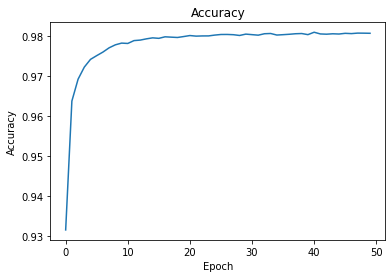

In [65]:
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

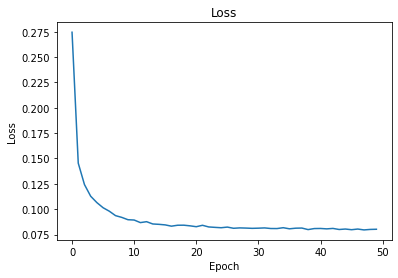

In [41]:
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [44]:
predicted_valid = model.predict(x_valid)

In [45]:
predicted_valid = [labels[np.argmax(x)] for x in predicted_valid]
x_valid = [[chr(x) for x in y[2 + max_num_features: 2 + max_num_features * 2]] for y in x_valid]
x_valid = [''.join(x) for x in x_valid]
x_valid = [re.sub('a+$', '', x) for x in x_valid]

In [46]:
gc.collect()

59956

In [47]:
df_predicted_valid = pd.DataFrame(columns=['data', 'predict'])
df_predicted_valid['data'] = x_valid
df_predicted_valid['predict'] = predicted_valid
df_predicted_valid.to_csv('validation_pred_lstm.csv')

In [63]:
df_predicted_valid.head(30)

,data,predict
0,"1,246 km² ",MONEY
1,London    ,PLAIN
2,Etales    ,PLAIN
3,window    ,PLAIN
4,cancer    ,PLAIN
5,Macclesfie,PLAIN
6,ت         ,VERBATIM
7,of        ,PLAIN
8,to        ,PLAIN
9,Dhruva    ,PLAIN


In [49]:
test_dataset = pd.read_csv("input/en_test.csv")

In [50]:
test_data = test_dataset['before'].values

In [51]:
def make_encoded_space_padded_tokens(data, max_num_features, space_char):
    space_padded_tokens = list()
    for before_value in data:
        space_padded_token = np.ones(max_num_features, dtype=int) * space_char
        before_value_c_str = list(str(before_value))
        for before_value_char, i in zip(before_value_c_str, range(max_num_features)):
            space_padded_token[i] = ord(before_value_char)
        space_padded_tokens.append(space_padded_token)
    return space_padded_tokens

In [52]:
test_data = make_encoded_space_padded_tokens(data=test_data, max_num_features=max_num_features, space_char=0)

In [53]:
test_data = np.array(make_flat_context_windows(data=test_data, pad_size=1, max_num_features=max_num_features, boundary_letter=-1))

In [54]:
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))

In [55]:
predicted_data = model.predict(test_data)

In [56]:
predicted_data = [labels[np.argmax(char)] for char in predicted_data]
test_data = [[chr(wrd) for wrd in char[2 + max_num_features: 2 + max_num_features * 2]] for char in test_data]
test_data = [''.join(wrd) for wrd in test_data]
test_data = [re.sub('a+$', '', wrd) for wrd in test_data]

In [57]:
gc.collect()

20

In [58]:
df_predicted = pd.DataFrame(columns=['data', 'predict'])
df_predicted['data'] = test_data
df_predicted['predict'] = predicted_data
df_predicted.to_csv('pred_lstm.csv')

In [61]:
df_predicted.head(30)

,data,predict
0,Another   ,PLAIN
1,religious ,PLAIN
2,family    ,PLAIN
3,is        ,LETTERS
4,of        ,PLAIN
5,Hazrat    ,PLAIN
6,Sayyed    ,PLAIN
7,Ahmad     ,PLAIN
8,and       ,PLAIN
9,his       ,PLAIN


In [59]:
all_classes = set(training_data['class'].unique())
predicted_classes = set(df_predicted['predict'].unique())
missing_classes = all_classes - predicted_classes

In [60]:
print("Missing Classes:")
for cls in missing_classes: print(cls)

Missing Classes:
FRACTION
DECIMAL
DIGIT
ADDRESS
ELECTRONIC
TIME


In [62]:
predicted_classes

{'CARDINAL',
 'DATE',
 'LETTERS',
 'MEASURE',
 'MONEY',
 'ORDINAL',
 'PLAIN',
 'PUNCT',
 'TELEPHONE',
 'VERBATIM'}